# Connect Four – Maskable PPO (Colab/Kaggle ready)

This notebook trains SB3-contrib `MaskablePPO` on the custom Connect Four env, logs evals vs fixed opponents, runs an ablation, and plots win rates/loss curves.

Steps:
1. Install deps.
2. Clone/pull repo and `cd` into `rl_connect4`.
3. Run smoke training, ablation, and plots.

In [1]:
# Install dependencies (rerun on fresh runtime)
!pip install -q stable-baselines3[extra] sb3-contrib gymnasium pygame numpy torch pandas matplotlib seaborn

In [2]:
import os, sys, pathlib

REPO_URL = "https://github.com/UmerSR/Connect-Four-RL.git"
WORKSPACE = "/content/Connect-Four-RL"

if not os.path.exists(WORKSPACE):
    !git clone $REPO_URL $WORKSPACE
else:
    %cd $WORKSPACE
    !git pull --ff-only

%cd $WORKSPACE/rl_connect4
sys.path.insert(0, WORKSPACE)
print("CWD:", os.getcwd())

Cloning into '/content/Connect-Four-RL'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 34 (delta 5), reused 34 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 62.29 KiB | 20.76 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Connect-Four-RL/rl_connect4
CWD: /content/Connect-Four-RL/rl_connect4


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from envs.connect_four_env import ConnectFourEnv
from agents.simple_agents import RandomAgent, HeuristicAgent
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure

sns.set_theme(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


device(type='cuda')

In [4]:
# Env builders with action masking
def mask_fn(arg):
    if isinstance(arg, dict):
        return arg["action_mask"].astype(bool)
    if hasattr(arg, "action_masks"):
        return arg.action_masks()
    raise TypeError(f"Unsupported mask_fn input: {type(arg)}")

def make_env(seed=None):
    def _init():
        env = ConnectFourEnv(seed=seed)
        env = ActionMasker(env, mask_fn)
        return env
    return _init

def make_vec_envs(n_envs=4, seed=0):
    env_fns = [make_env(seed + i if seed is not None else None) for i in range(n_envs)]
    vec = DummyVecEnv(env_fns)
    vec = VecMonitor(vec)
    return vec

eval_env = ActionMasker(ConnectFourEnv(), mask_fn)
obs, _ = eval_env.reset()
print("Obs keys:", obs.keys(), "action_mask shape:", obs["action_mask"].shape)

Obs keys: dict_keys(['observation', 'action_mask']) action_mask shape: (7,)


In [5]:
# Enhanced evaluation helpers
def evaluate_vs_opponent(model, env, opponent, episodes=20, deterministic=False):
    results = {"wins": 0, "losses": 0, "draws": 0, "illegal": 0}
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        info = {}
        while not done:
            if env.unwrapped.current_player == 0:
                action, _ = model.predict(obs, deterministic=deterministic)
            else:
                action = opponent.select_action(env.unwrapped)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        if info.get("illegal_move"):
            results["illegal"] += 1
        elif info.get("draw"):
            results["draws"] += 1
        elif info.get("winner") == 0:
            results["wins"] += 1
        else:
            results["losses"] += 1
    results["win_rate"] = results["wins"] / max(1, episodes)
    return results

class EnhancedEvalRecorder(BaseCallback):
    def __init__(self, eval_env, eval_freq=2000, n_eval_episodes=50):
        super().__init__()
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.history = []
        self.best_mean_reward = -np.inf

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            mean_r, std_r = evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                warn=False,
                deterministic=False,
            )
            rand_eval = evaluate_vs_opponent(
                self.model,
                ActionMasker(ConnectFourEnv(), mask_fn),
                RandomAgent(),
                episodes=20,
                deterministic=False,
            )
            heur_eval = evaluate_vs_opponent(
                self.model,
                ActionMasker(ConnectFourEnv(), mask_fn),
                HeuristicAgent(),
                episodes=20,
                deterministic=False,
            )
            self.history.append({
                "timesteps": self.num_timesteps,
                "mean_reward": mean_r,
                "std_reward": std_r,
                "win_rate_random": rand_eval["win_rate"],
                "win_rate_heuristic": heur_eval["win_rate"],
            })
            self.best_mean_reward = max(self.best_mean_reward, mean_r)
        return True

def train_maskable_ppo(run_name: str, total_timesteps: int, hyperparams: dict, n_envs: int = 4, eval_freq: int = 2000, n_eval_episodes: int = 50):
    log_dir = f"/content/Connect-Four-RL/outputs/{run_name}"
    pathlib.Path(log_dir).mkdir(parents=True, exist_ok=True)

    vec_env = make_vec_envs(n_envs=n_envs)
    model = MaskablePPO(
        "MultiInputPolicy",
        vec_env,
        verbose=0,
        tensorboard_log=log_dir,
        device=device,
        **hyperparams,
    )
    model.set_logger(configure(log_dir, ["stdout", "csv"]))

    callback = EnhancedEvalRecorder(eval_env, eval_freq=eval_freq, n_eval_episodes=n_eval_episodes)
    model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=False)

    mean_r, std_r = evaluate_policy(
        model,
        eval_env,
        n_eval_episodes=n_eval_episodes,
        warn=False,
        deterministic=False,
    )
    rand_eval = evaluate_vs_opponent(model, ActionMasker(ConnectFourEnv(), mask_fn), RandomAgent(), episodes=50, deterministic=False)
    heur_eval = evaluate_vs_opponent(model, ActionMasker(ConnectFourEnv(), mask_fn), HeuristicAgent(), episodes=50, deterministic=False)
    callback.history.append({
        "timesteps": total_timesteps,
        "mean_reward": mean_r,
        "std_reward": std_r,
        "win_rate_random": rand_eval["win_rate"],
        "win_rate_heuristic": heur_eval["win_rate"],
    })

    return model, callback.history, log_dir

hyperparams_example = {
    "learning_rate": 3e-4,
    "gamma": 0.99,
    "clip_range": 0.2,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "n_steps": 1024,
    "batch_size": 1024,
    "gae_lambda": 0.95,
}
hyperparams_example

{'learning_rate': 0.0003,
 'gamma': 0.99,
 'clip_range': 0.2,
 'ent_coef': 0.01,
 'vf_coef': 0.5,
 'n_steps': 1024,
 'batch_size': 1024,
 'gae_lambda': 0.95}

In [6]:
# Smoke run
smoke_timesteps = 20000
smoke_model, smoke_history, smoke_logdir = train_maskable_ppo(
    run_name="smoke",
    total_timesteps=smoke_timesteps,
    hyperparams=hyperparams_example,
    n_envs=4,
    eval_freq=2000,
    n_eval_episodes=50,
)
pd.DataFrame(smoke_history)

Logging to /content/Connect-Four-RL/outputs/smoke


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.2      |
| time/              |          |
|    fps             | 700      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 22.3         |
|    ep_rew_mean          | 1.26         |
| time/                   |              |
|    fps                  | 566          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0061081406 |
|    clip_fraction        | 0.0031       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.91        |
|    explained_variance   | -1.42        |
|    learning_r

,timesteps,mean_reward,std_reward,win_rate_random,win_rate_heuristic
0,8000,0.429,0.956509,0.30,0.00
1,16000,0.489,0.963446,0.45,0.05
2,20000,0.613,0.915249,0.40,0.02


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
# Ablation over common hyperparameters
ablation_grid = [
    {"tag": "lr_3e-4_clip_0.2", "learning_rate": 3e-4, "clip_range": 0.2, "gamma": 0.99, "gae_lambda": 0.95},
    {"tag": "lr_1e-3_clip_0.2", "learning_rate": 1e-3, "clip_range": 0.2, "gamma": 0.99, "gae_lambda": 0.95},
    {"tag": "lr_3e-4_clip_0.1", "learning_rate": 3e-4, "clip_range": 0.1, "gamma": 0.99, "gae_lambda": 0.95},
    {"tag": "lr_3e-4_gamma_0.995", "learning_rate": 3e-4, "clip_range": 0.2, "gamma": 0.995, "gae_lambda": 0.95},
    {"tag": "lr_3e-4_ent_0.02", "learning_rate": 3e-4, "clip_range": 0.2, "gamma": 0.99, "gae_lambda": 0.95, "ent_coef": 0.02},
]

common_params = {
    "n_steps": 1024,
    "batch_size": 1024,
    "vf_coef": 0.5,
    "ent_coef": 0.01,
}

ablation_results = []
all_histories = []

total_timesteps = 200000
for cfg in ablation_grid:
    hyper_cfg = {k: v for k, v in cfg.items() if k != "tag"}
    hyper = {**common_params, **hyper_cfg}
    run_name = f"ablate_{cfg['tag']}"
    print(f"\n=== Training {run_name} ===")
    model, history, log_dir = train_maskable_ppo(
        run_name=run_name,
        total_timesteps=total_timesteps,
        hyperparams=hyper,
        n_envs=8,
        eval_freq=2000,
        n_eval_episodes=50,
    )
    if len(history) > 0:
        best = max(history, key=lambda h: h.get("win_rate_random", h.get("mean_reward", -np.inf)))
        best_mean = best.get("mean_reward", np.nan)
        best_wr_rand = best.get("win_rate_random", np.nan)
        best_wr_heur = best.get("win_rate_heuristic", np.nan)
    else:
        best_mean = np.nan
        best_wr_rand = np.nan
        best_wr_heur = np.nan

    ablation_results.append({
        "run": run_name,
        "best_mean_reward": best_mean,
        "best_win_rate_random": best_wr_rand,
        "best_win_rate_heuristic": best_wr_heur,
        "log_dir": log_dir,
        **cfg,
    })
    hist_df = pd.DataFrame(history)
    hist_df["run"] = run_name
    all_histories.append(hist_df)

ablation_df = pd.DataFrame(ablation_results)
ablation_df


=== Training ablate_lr_3e-4_clip_0.2 ===
Logging to /content/Connect-Four-RL/outputs/ablate_lr_3e-4_clip_0.2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 1.23     |
| time/              |          |
|    fps             | 1027     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.5        |
|    ep_rew_mean          | 1.25        |
| time/                   |             |
|    fps                  | 857         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009776344 |
|    clip_fraction        | 0.0225      |
|    clip_range           | 0.2         |
|   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.8     |
|    ep_rew_mean     | 1.26     |
| time/              |          |
|    fps             | 1011     |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.5        |
|    ep_rew_mean          | 1.24        |
| time/                   |             |
|    fps                  | 848         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009385729 |
|    clip_fraction        | 0.0856      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | -1.09       |
|    learning_rate        | 0.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.2     |
|    ep_rew_mean     | 1.21     |
| time/              |          |
|    fps             | 1009     |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20.4         |
|    ep_rew_mean          | 1.24         |
| time/                   |              |
|    fps                  | 849          |
|    iterations           | 2            |
|    time_elapsed         | 19           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0025427109 |
|    clip_fraction        | 0.0843       |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.9         |
|    explained_variance   | -0.484       |
|    learning_r

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | 1.23     |
| time/              |          |
|    fps             | 1027     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.8        |
|    ep_rew_mean          | 1.23        |
| time/                   |             |
|    fps                  | 854         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.008396429 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | -6.75       |
|    learning_rate        | 0.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.23     |
| time/              |          |
|    fps             | 1020     |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19.9        |
|    ep_rew_mean          | 1.23        |
| time/                   |             |
|    fps                  | 857         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011458645 |
|    clip_fraction        | 0.0556      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | -0.911      |
|    learning_rate        | 0.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,run,best_mean_reward,best_win_rate_random,best_win_rate_heuristic,log_dir,tag,learning_rate,clip_range,gamma,gae_lambda,ent_coef
0,ablate_lr_3e-4_clip_0.2,0.758,0.80,0.00,/content/Connect-Four-RL/outputs/ablate_lr_3e-...,lr_3e-4_clip_0.2,0.0003,0.2,0.990,0.95,NaN
1,ablate_lr_1e-3_clip_0.2,1.099,0.75,0.05,/content/Connect-Four-RL/outputs/ablate_lr_1e-...,lr_1e-3_clip_0.2,0.0010,0.2,0.990,0.95,NaN
2,ablate_lr_3e-4_clip_0.1,0.849,0.65,0.10,/content/Connect-Four-RL/outputs/ablate_lr_3e-...,lr_3e-4_clip_0.1,0.0003,0.1,0.990,0.95,NaN
3,ablate_lr_3e-4_gamma_0.995,0.670,0.70,0.00,/content/Connect-Four-RL/outputs/ablate_lr_3e-...,lr_3e-4_gamma_0.995,0.0003,0.2,0.995,0.95,NaN
4,ablate_lr_3e-4_ent_0.02,0.778,0.60,0.00,/content/Connect-Four-RL/outputs/ablate_lr_3e-...,lr_3e-4_ent_0.02,0.0003,0.2,0.990,0.95,0.02


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


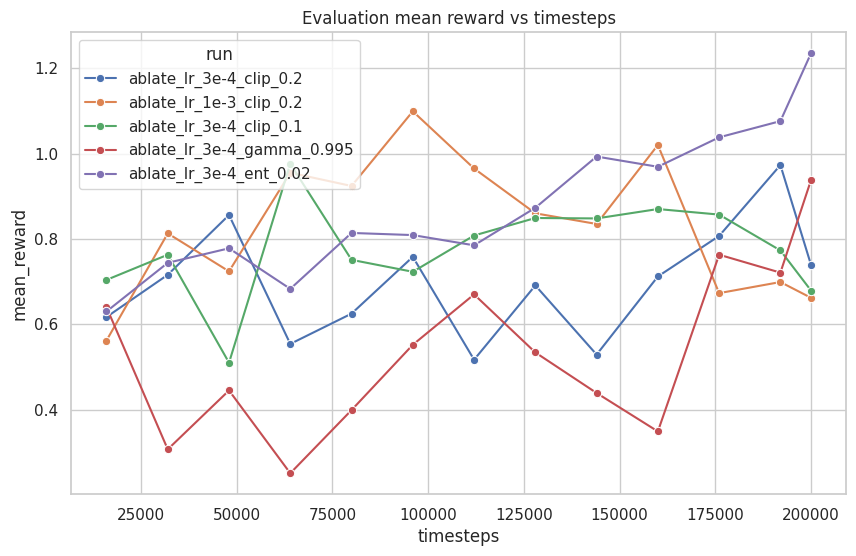

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


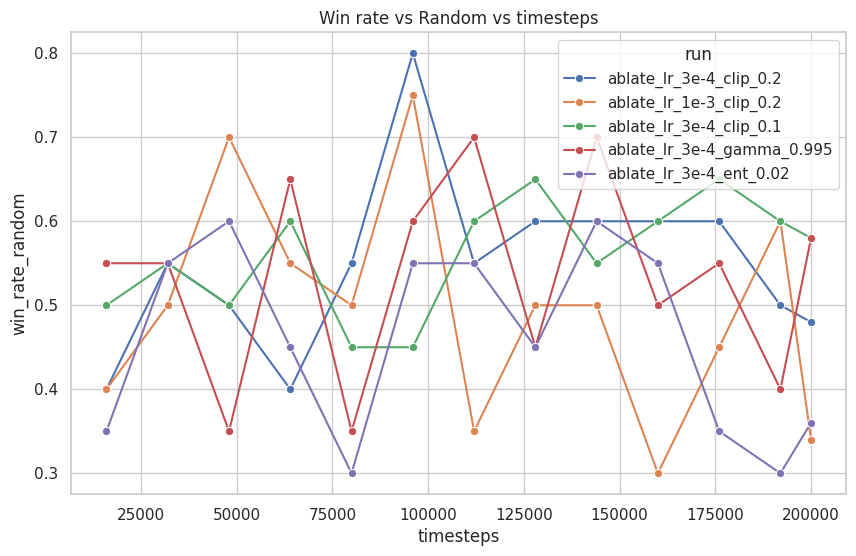

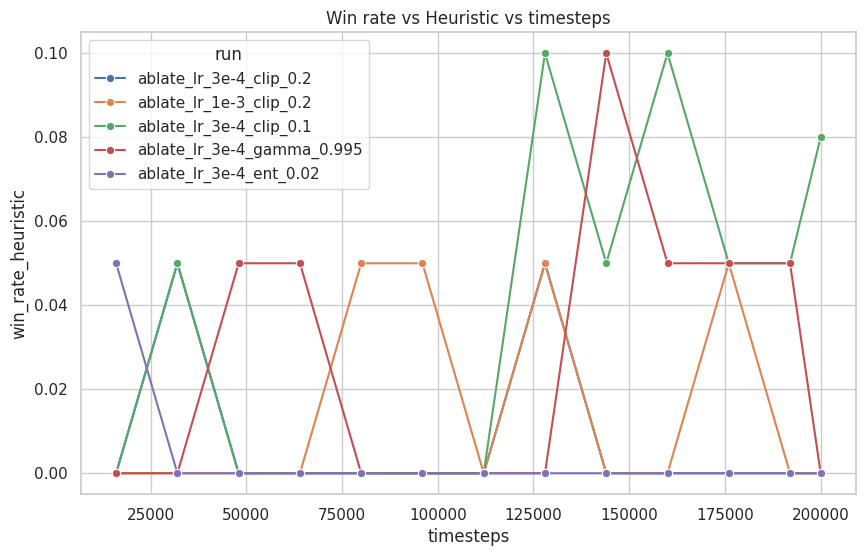

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


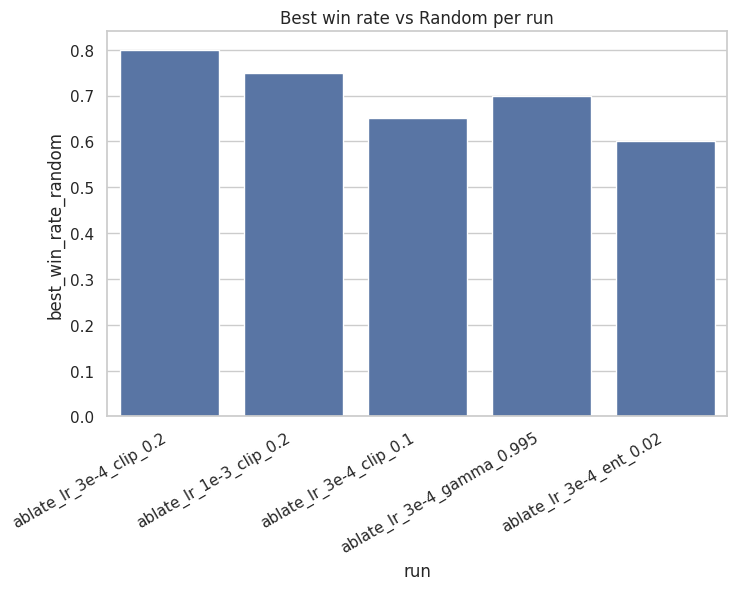

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
# Plot eval curves (mean reward and win rates)
if all_histories:
    hist_all_df = pd.concat(all_histories, ignore_index=True)
    if hist_all_df.empty:
        print("No eval data recorded yet.")
    else:
        if "timesteps" not in hist_all_df.columns and "time/total_timesteps" in hist_all_df.columns:
            hist_all_df = hist_all_df.rename(columns={"time/total_timesteps": "timesteps"})

        if "timesteps" in hist_all_df.columns and "mean_reward" in hist_all_df.columns:
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=hist_all_df, x="timesteps", y="mean_reward", hue="run", marker="o")
            plt.title("Evaluation mean reward vs timesteps")
            plt.show()
        if "timesteps" in hist_all_df.columns and "win_rate_random" in hist_all_df.columns:
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=hist_all_df, x="timesteps", y="win_rate_random", hue="run", marker="o")
            plt.title("Win rate vs Random vs timesteps")
            plt.show()
        if "timesteps" in hist_all_df.columns and "win_rate_heuristic" in hist_all_df.columns:
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=hist_all_df, x="timesteps", y="win_rate_heuristic", hue="run", marker="o")
            plt.title("Win rate vs Heuristic vs timesteps")
            plt.show()

    if not ablation_df.empty:
        plt.figure(figsize=(8, 5))
        sns.barplot(data=ablation_df, x="run", y="best_win_rate_random")
        plt.xticks(rotation=30, ha="right")
        plt.title("Best win rate vs Random per run")
        plt.show()
    else:
        print("No ablation summary to plot yet.")
else:
    print("No history to plot yet.")

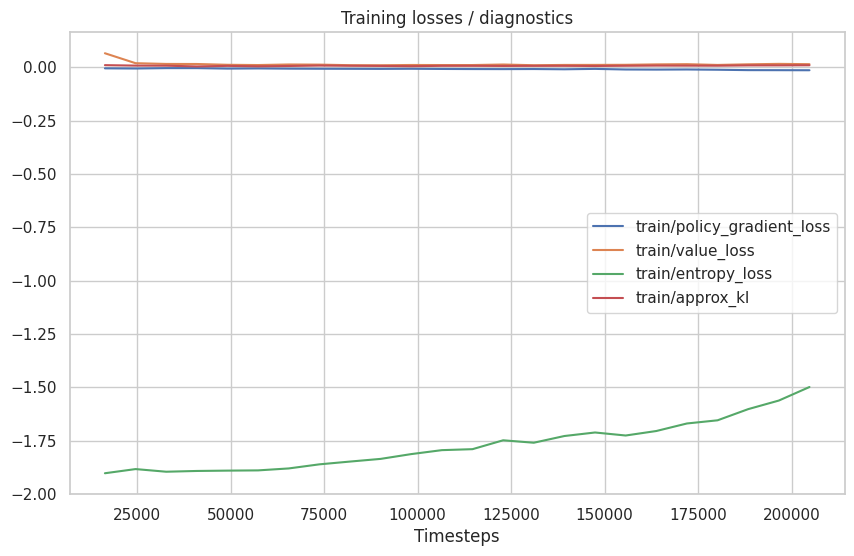

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
# Plot training losses from the first run's CSV logs (if present)
loss_keys = [
    "train/policy_gradient_loss",
    "train/value_loss",
    "train/entropy_loss",
    "train/approx_kl",
]

if len(ablation_results) > 0:
    sample_log = pathlib.Path(ablation_results[0]["log_dir"]) / "progress.csv"
elif 'smoke_logdir' in globals():
    sample_log = pathlib.Path(smoke_logdir) / "progress.csv"
else:
    sample_log = None

if sample_log and sample_log.exists():
    df_log = pd.read_csv(sample_log)
    available = [k for k in loss_keys if k in df_log.columns]
    if available:
        plt.figure(figsize=(10, 6))
        for k in available:
            plt.plot(df_log["time/total_timesteps"], df_log[k], label=k)
        plt.legend()
        plt.xlabel("Timesteps")
        plt.title("Training losses / diagnostics")
        plt.show()
    else:
        print("No loss keys available in progress.csv")
else:
    print("No progress.csv found yet.")

In [10]:
!cd /content/Connect-Four-RL && zip -r outputs.zip outputs

from google.colab import files
files.download('/content/Connect-Four-RL/outputs.zip')


  adding: outputs/ (stored 0%)
  adding: outputs/ablate_lr_3e-4_ent_0.02/ (stored 0%)
  adding: outputs/ablate_lr_3e-4_ent_0.02/progress.csv (deflated 52%)
  adding: outputs/ablate_lr_3e-4_gamma_0.995/ (stored 0%)
  adding: outputs/ablate_lr_3e-4_gamma_0.995/progress.csv (deflated 53%)
  adding: outputs/ablate_lr_3e-4_clip_0.1/ (stored 0%)
  adding: outputs/ablate_lr_3e-4_clip_0.1/progress.csv (deflated 53%)
  adding: outputs/ablate_lr_1e-3_clip_0.2/ (stored 0%)
  adding: outputs/ablate_lr_1e-3_clip_0.2/progress.csv (deflated 52%)
  adding: outputs/ablate_lr_3e-4_clip_0.2/ (stored 0%)
  adding: outputs/ablate_lr_3e-4_clip_0.2/progress.csv (deflated 53%)
  adding: outputs/smoke/ (stored 0%)
  adding: outputs/smoke/progress.csv (deflated 48%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>